In [419]:
%load_ext autoreload
%matplotlib inline
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [420]:
import os
import re
import io
import ast
import sys
import json
import boto3
import pymongo 
import subprocess
import numpy as np
import pandas as pd
import seaborn as sns

from tqdm import tqdm
from matplotlib import cm
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D

from PIL import Image
from urllib import request
from collections import Counter

sys.path.append("../")
import cabutils

In [421]:
sns.set_style("darkgrid")
sns.set_context("notebook")

In [422]:
from matplotlib import rcParams
rcParams["font.size"] = 18
rcParams["figure.titlesize"] = 26

In [485]:
projName = "mlve"
experiment = "tdw"
experimentName = f"{experiment}-surface-normals"
S3_BUCKET_NAME = "mlve-v1"

attention_check = "attention_check"
batch_idx = "batch_idx"

To download data (@Yoni only), run: 
ssh -i ~/.aws/cocosci_ec2.pem -NL 8000:localhost:27017  ubuntu@ec2-3-90-78-57.compute-1.amazonaws.com

# Downloading data from ec2 server (mostly just instructions for thomas)

In `settings.conf` change the `MONGODB_PORT` to 8000, and the `MONGODB_HOST` to `localhost`. Then run the ssh port into the ec2 server: 

```
ssh -i path/to/pem/key/maybe-named-something-like/Cocosci_WebExperiments.pem -fNL 8000:localhost:27017 ubuntu@ec2-54-91-252-25.compute-1.amazonaws.com
```

Change the path to the pem key, but otherwise this should all stay the same.

In [486]:
conn = cabutils.get_db_connection()
db = conn[projName + "_inputs"]
col = db[experimentName]

Checking database connection...
Connection established!


In [487]:
db.list_collection_names()

['gestalt_shapegen_surface-normals',
 'hypersim_v2-depth-estimation',
 'nsd-surface-normals',
 'tdw-surface-normals',
 'nsd_depth-estimation',
 'tdw-depth-estimation-pilot',
 'hypersim_surface-normals',
 'nsd_surface-normals',
 'tdw-depth-estimation',
 'gestalt_shapegen-surface-normals',
 'nsd-depth-estimation',
 'hypersim_v3-depth-estimation-split-half',
 'hypersim_v2-depth-estimation-pilot',
 'hypersim_v3-segmentation-split-half',
 'hypersim_depth-estimation',
 'hypersim_v3-surface-normals',
 'gestalt_shapegen-surface-normals-split-half',
 'hypersim_surface-normals-splithalf',
 'hypersim_v2-segmentation-split-half',
 'gestalt_shapegen-segmentation-split-half',
 'hypersim_v2-object-loc-split-half',
 'hypersim_v2-surface-normals',
 'gestalt_shapegen-depth-estimation-pilot',
 'nsd-object-loc-split-half',
 'nsd-depth-estimation-pilot',
 'gestalt_shapegen_video-object-loc',
 'tdw-surface-normals-split-half',
 'gestalt_object-loc',
 'gestalt_shapegen-depth-estimation',
 'nsd-object-loc',
 

In [488]:
def results_to_df():
    results = []
    cursor = col.find({})
    for document in cursor:
        results.append(document)
    
    data = []
    print(results[0]["data"]["notes"])
    print(results[0]["data"]["creation_date"])
    for row in results[0]["data"]["trials"]:
        data.append(row)
    df = pd.DataFrame(data)
    return df

df = results_to_df()


Large scale data collection single batch. Surface Normals sampled from a uniform spherical distribution
2022-19-10, 21H:26:06


In [489]:
df.head()


,imageMetadata,imageURL,trialType,trueArrowDirection,isDuplicate,arrowPosition,arrowPixelPosition,randomizeArrowInitialDirection,attentionCheck,batchIdx
0,"{'model_split': 'model_split_0', 'trial_num': ...",https://mlve-v1.s3.us-east-2.amazonaws.com/tdw...,unsupervised,"[-0.6018971226534832, -0.7112206400226282, 0.3...",False,"[1.6933072407045007, -0.41080234833659457, 0]","[340, 235]",True,False,0
1,"{'model_split': 'model_split_0', 'trial_num': ...",https://mlve-v1.s3.us-east-2.amazonaws.com/tdw...,unsupervised,"[0.6140838186159031, -0.595466539743669, 0.517...",False,"[-1.853620352250489, -0.8717025440313115, 0]","[163, 212]",True,False,0
2,"{'model_split': 'model_split_0', 'trial_num': ...",https://mlve-v1.s3.us-east-2.amazonaws.com/tdw...,unsupervised,"[-0.9412982351511422, -0.33320850752990894, 0....",False,"[-0.19037181996086083, 0.13025440313111591, 0]","[246, 262]",True,False,0
3,"{'model_split': 'model_split_0', 'trial_num': ...",https://mlve-v1.s3.us-east-2.amazonaws.com/tdw...,unsupervised,"[0.6953061326788489, 0.2692373505952938, 0.666...",False,"[0.010019569471624301, 0.31060665362035245, 0]","[256, 271]",True,False,0
4,"{'model_split': 'model_split_0', 'trial_num': ...",https://mlve-v1.s3.us-east-2.amazonaws.com/tdw...,unsupervised,"[-0.6482923009597107, -0.3334714509435568, 0.6...",False,"[-4.1180430528375735, 2.5149119373776907, 0]","[50, 381]",True,False,0


In [490]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136 entries, 0 to 135
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   imageMetadata                   130 non-null    object
 1   imageURL                        136 non-null    object
 2   trialType                       136 non-null    object
 3   trueArrowDirection              136 non-null    object
 4   isDuplicate                     136 non-null    bool  
 5   arrowPosition                   136 non-null    object
 6   arrowPixelPosition              136 non-null    object
 7   randomizeArrowInitialDirection  136 non-null    bool  
 8   attentionCheck                  136 non-null    bool  
 9   batchIdx                        136 non-null    int64 
dtypes: bool(3), int64(1), object(6)
memory usage: 8.0+ KB


In [491]:
def download_from_s3(url, resource_type="image"):
    s3 = boto3.resource('s3', region_name="us-east-2")
    bucket = s3.Bucket(S3_BUCKET_NAME)
    item = bucket.Object(url)
    if resource_type == "image":
        file_stream = io.BytesIO()
        item.download_fileobj(file_stream)
        img = Image.open(file_stream)
        return img
    
    else:
        return item

In [492]:
def download_from_url(url):
    obj = request.urlretrieve(url)
    image = Image.open(obj[0])
    return image

In [493]:
def draw_circles(ax, locs, size=10, edgecolor="red", facecolor="none", lw=2):
    """
    draws circle patches on an image at specified locations
    """
    for point in locs:
        circ = patches.Circle((point[1], point[0]), size, ec=edgecolor, fc=facecolor, lw=lw)
        ax.add_patch(circ)
    return ax


## Plot the distribution of surface normals

In [494]:
def geodesic_dist(a, b):
    a = np.array(a)
    b = np.array(b)
    if not a.shape or not b.shape:
        print("No data for: ", a, b)
        return float("nan")

    a = a / np.linalg.norm(a)
    b = b / np.linalg.norm(b)
    
    dist = np.arccos(a.dot(b))
    return dist

In [495]:
### from tqdm.notebook import tqdm

def near( p, pntList, d0 ):
    cnt=0
    for pj in pntList:
        dist=geodesic_dist(p, pj)
        if dist < d0:
            cnt += 1 - dist/d0
    return cnt


"""
https://stackoverflow.com/questions/22128909/plotting-the-temperature-distribution-on-a-sphere-with-python
"""

def calculate_heatmap(pointList, threshold=0.5):

    u = np.linspace( 0, 2 * np.pi, 20)
    v = np.linspace( 0, np.pi, 20)

    # create the sphere surface
    XX = np.outer( np.cos( u ), np.sin( v ) )
    YY = np.outer( np.sin( u ), np.sin( v ) )
    ZZ = np.outer( np.ones( np.size( u ) ), np.cos( v ) )

    pbar = tqdm(total = len(XX) * len(XX[0]))

    WW = XX.copy()
    for i in range( len( XX ) ):
        for j in range( len( XX[0] ) ):
            x = XX[ i, j ]
            y = YY[ i, j ]
            z = ZZ[ i, j ]

            dist = near(np.array( [x, y, z ] ), pointList, threshold)
            WW[ i, j ] = dist
            pbar.update(1)

    heatmap = WW / np.amax( WW )
    return heatmap, (XX, YY, ZZ)

In [496]:
true_directions = np.array([x for x in df["trueArrowDirection"]])
gt_heatmap, true_coords = calculate_heatmap(true_directions)

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:00<00:00, 1556.72it/s]


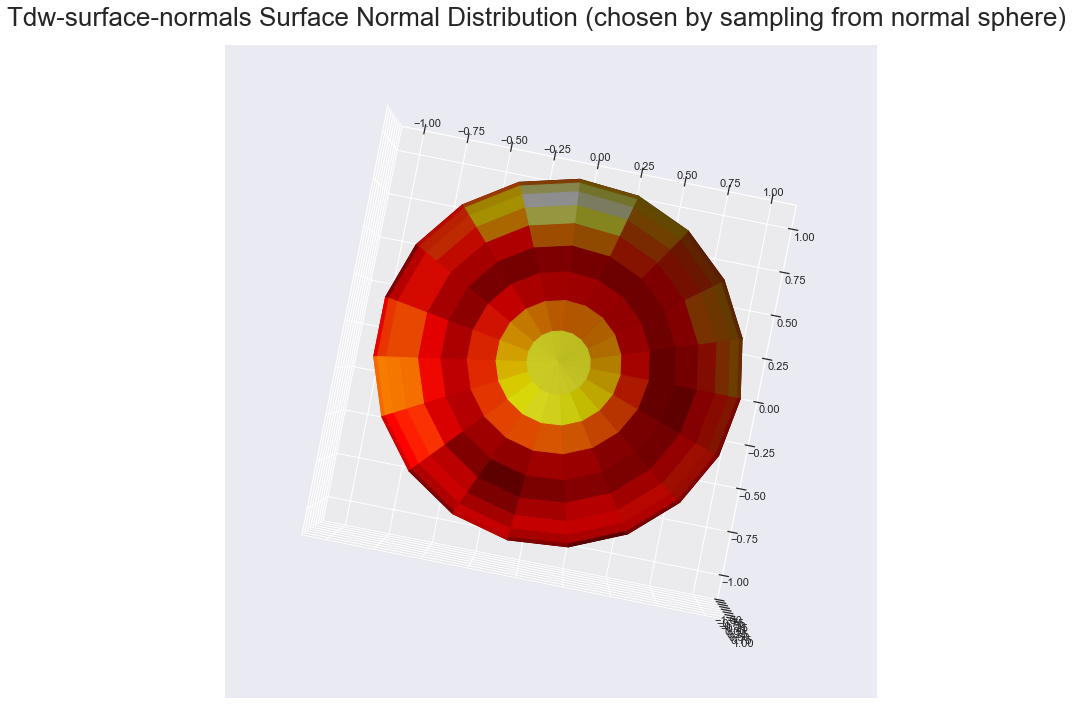

In [508]:
def plot_normals(coords, normal_map, tile=False):
    fig = plt.figure(figsize=(16,12))
    rotation = 280
    angle = 90
    if tile:
        c = 0
        for i in range(3):
            angle += 90
            rotation = 0
            for j in range(3):
                c += 1
                ax = fig.add_subplot(3, 3, c, projection='3d')
                x, y, z = coords
                ax.plot_surface(x, y, z, cstride=1, rstride=1, facecolors=cm.hot(normal_map))
                ax.view_init(angle, rotation)
                rotation += 90
        
    else:
        ax = fig.add_subplot(111, projection='3d')
        x, y, z = coords
        ax.plot_surface(x, y, z, cstride=1, rstride=1, facecolors=cm.hot(normal_map))
        ax.view_init(angle, rotation)
        
    dataset = experimentName.split("_")[0]
    plt.suptitle(dataset.capitalize() + " Surface Normal Distribution (chosen by sampling from normal sphere)", y=0.925)
    plt.show()

plot_normals(true_coords, gt_heatmap)

In [474]:
normals = np.array(df["trueArrowDirection"].tolist())

print(normals.shape)
for i in range(3):
    print(np.min(normals[:, i]), np.max(normals[:, i]))

(136, 3)
-0.994459633910554 0.9719336698050102
-0.9859079706872735 0.9825848719612716
0.00048738669861851257 0.9952823598661185


(1000, 3, 1)


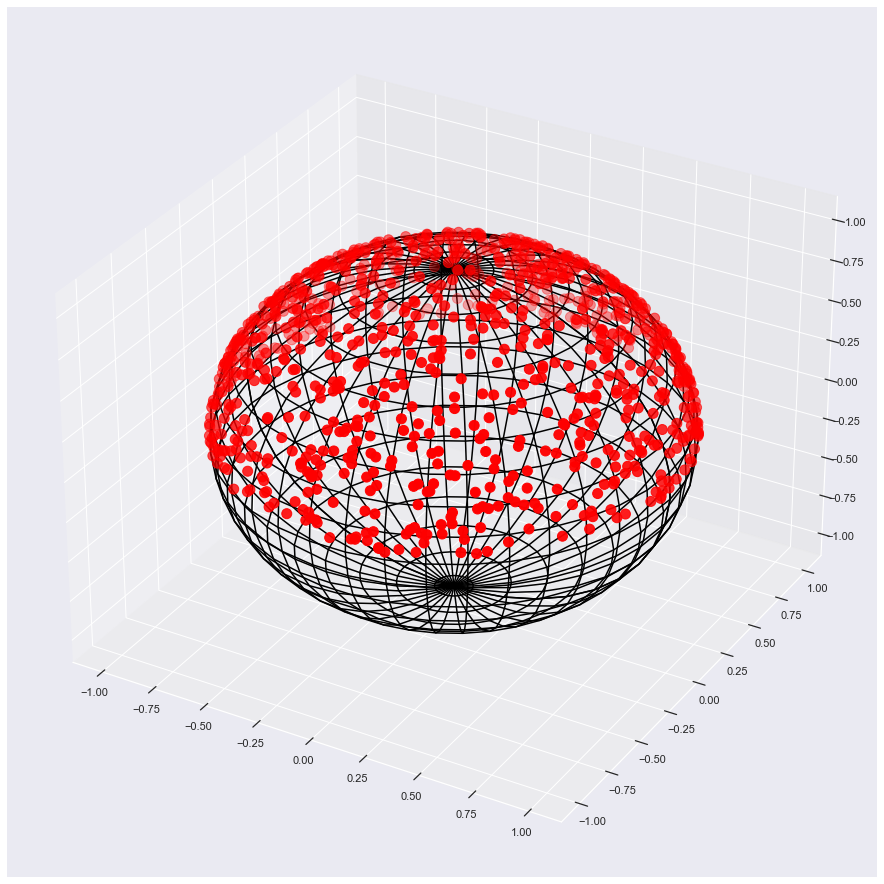

In [399]:
def sample_normal(ndim=3):
    while True:
        vec = np.random.randn(ndim, 1)
        vec /= np.linalg.norm(vec, axis=0)

        if vec[-1] > 0:
            return vec


from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import axes3d

phi = np.linspace(0, np.pi, 20)
theta = np.linspace(0, 2 * np.pi, 40)
x = np.outer(np.sin(theta), np.cos(phi))
y = np.outer(np.sin(theta), np.sin(phi))
z = np.outer(np.cos(theta), np.ones_like(phi))

coords = []
for i in range(1000):
    xi, yi, zi = sample_normal()
    coords.append([xi,yi,zi])
    
coords = np.array(coords)
print(coords.shape)
xi = coords[:, 0].squeeze()
yi = coords[:, 1].squeeze()
zi = coords[:, 2].squeeze()

fig, ax = plt.subplots(1, 1, subplot_kw={'projection':'3d', 'aspect':'auto'}, figsize=(16,16))
ax.plot_wireframe(x, y, z, color='k', rstride=1, cstride=1)
ax.scatter(xi, yi, zi, s=100, c='r', zorder=10)


## Visualize the distribution of sampled points on images

In [ ]:
plot_images = False

In [ ]:
if plot_images:
    save_dir = os.path.join(f"figures/{experimentName}")
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    sns.set_style("white")
    for url, row in df.groupby("imageURL"):
        point_locs = row["arrowPixelPosition"]
        locs = set()
        for point in point_locs:
            locs.add(tuple(point))

        locs = list(locs)
        image = download_from_url(url)
        plt.close()
        fig,ax = plt.subplots(1, figsize=(12, 12))
        ax.set_aspect('equal')

        ax = draw_circles(ax, locs, size=15, lw=4)
        ax = draw_circles(ax, locs, size=10, lw=4)

        ax.imshow(image)
    #     pixelPositions = row["arrowPixelPosition"]
    #     idfs = row["indicatorFinalDirection"]
    #     for i in range(len(pixelPositions)):
    #         loc = pixelPositions.iloc[i]
    #         ifd = idfs.iloc[i]
    #         r = lambda: np.random.randint(0,255)
    #         color = '#%02X%02X%02X' % (r(),r(),r())
    #         ax.quiver(loc[1], loc[0], ifd[0], ifd[2], scale=ifd[1], color=color, angles="xy", scale_units='y')

        save_title = url.split("/")[-1]
        plt.savefig(os.path.join(save_dir, save_title))
        plt.show()


    sns.set_style("darkgrid")   

In [ ]:
indicator_directions.shape, heatmap.shape

In [ ]:

fig = go.Figure(data=[go.Scatter3d(x=spherical_coords[0].flatten(), 
                                   y=spherical_coords[1].flatten(), 
                                   z=spherical_coords[2].flatten(),
                                   mode='markers',
                                   marker=dict(
                                    size=5,
                                    color=participant_heatmap.flatten(),                # set color to an array/list of desired values
                                    colorscale='inferno',   # choose a colorscale
                                    opacity=0.8
                                ))])
fig.update_layout({"title": f"{experimentName}: Participant Surface Normal Distribution"})

fig.show()


In [ ]:

fig = go.Figure(data=[go.Scatter3d(x=spherical_coords[0].flatten(), 
                                   y=spherical_coords[1].flatten(), 
                                   z=spherical_coords[2].flatten(),
                                   mode='markers',
                                   marker=dict(
                                    size=3,
                                    color=gt_heatmap.flatten() + np.random.random(3600),                # set color to an array/list of desired values
                                    colorscale='inferno',   # choose a colorscale
                                    opacity=0.8
                                ))])
fig.update_layout({"title": f"{experimentName}: Participant Surface Normal Distribution"})

fig.show()


[[1.         0.30062464]
 [0.30062464 1.        ]]
[[1.         0.26388538]
 [0.26388538 1.        ]]
[[1.         0.15651285]
 [0.15651285 1.        ]]


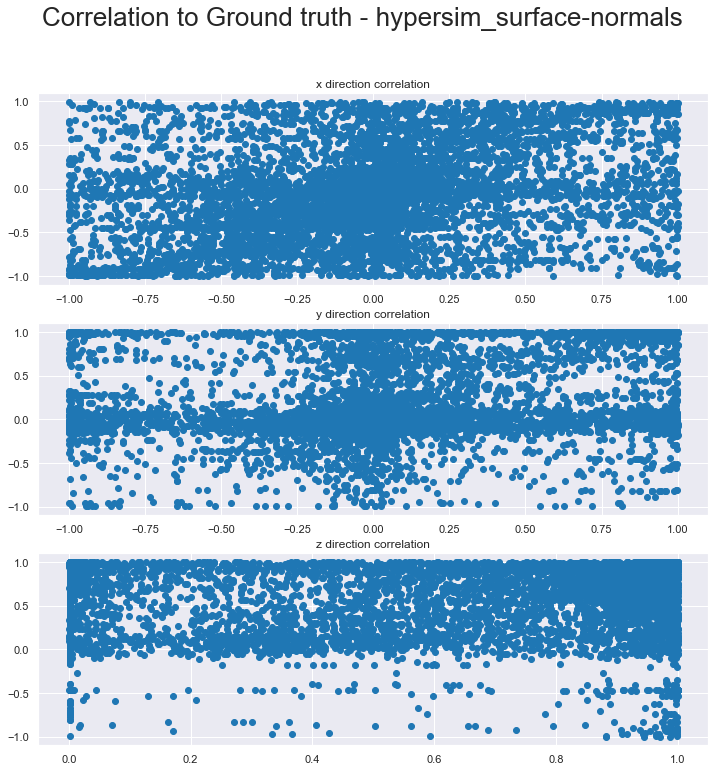

In [119]:
titles = ["x", "y", "z"]
fig, axs = plt.subplots(3, 1, figsize=(12, 12))
for i in range(3):
    axs[i].scatter(indicator_directions[:, i], true_directions[:, i])
    axs[i].set_title(titles[i] + " direction correlation")
    print(np.corrcoef(indicator_directions[:, i], true_directions[:, i]))
    
    
plt.suptitle("Correlation to Ground truth - " + experimentName)
plt.show()


In [ ]:
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(projection='3d')

ax.scatter(indicator_directions[:, 0], indicator_directions[:, 1], indicator_directions[:, 2], color="red", alpha=0.7)
ax.scatter(true_directions[:, 0], true_directions[:, 1], true_directions[:, 2], color="blue")

plt.show()

In [ ]:

fig = go.Figure(data=[go.Scatter3d(x=indicator_directions[:, 0], 
                                   y=indicator_directions[:, 1], 
                                   z=indicator_directions[:, 2],
                                   mode='markers',
                                   marker=dict(
                                    color="blue",
                                    size=5,
                                    opacity=0.8
                                ))])
fig.update_layout({"title": f"{experimentName}: Participant Surface Normal Distribution"})
fig.show()

fig = go.Figure(data=[go.Scatter3d(x=indicator_directions[:, 0], 
                                   y=indicator_directions[:, 1], 
                                   z=indicator_directions[:, 2],
                                   mode='markers',
                                   marker=dict(
                                    color="red",
                                    size=5,
                                    colorscale='Viridis',   # choose a colorscale
                                    opacity=0.8
                                ))])
fig.update_layout({"title": f"{experimentName}: Participant Surface Normal Distribution"})



fig.show()


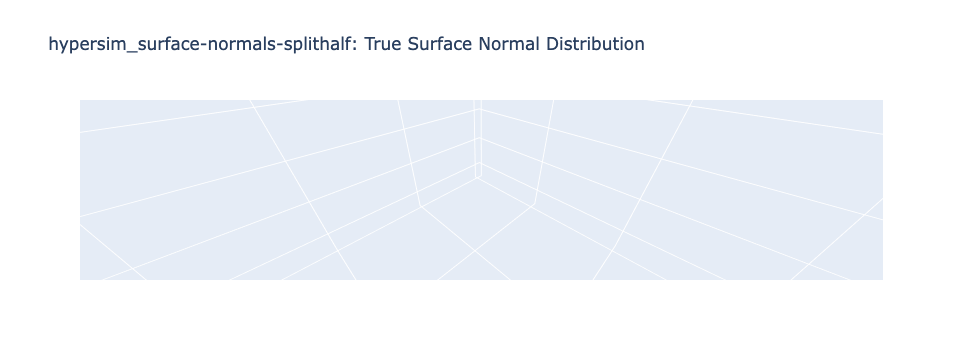

In [92]:

fig = go.Figure(data=[go.Scatter3d(x=true_directions[:, 0], 
                                   y=true_directions[:, 1], 
                                   z=true_directions[:, 2],
                                   mode='markers',
                                   marker=dict(
                                    size=5,
                                    color=true_directions[:, 0],                # set color to an array/list of desired values
                                    colorscale='Viridis',   # choose a colorscale
                                    opacity=0.8
                                ))])

fig.update_layout({"title": f"{experimentName}: True Surface Normal Distribution"})
fig.show()

NameError: name 'XX' is not defined

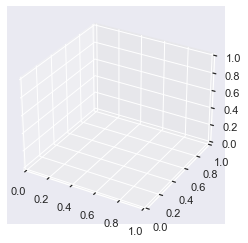

In [93]:
fig = plt.figure()
ax = fig.add_subplot( 1, 1, 1, projection='3d')

ax.plot_surface( XX, YY,  ZZ, cstride=1, rstride=1, facecolors=cm.jet( heatmap ) )
plt.show() 


In [94]:

fig = go.Figure(data=[go.Scatter3d(x=true_directions[:, 0], 
                                   y=true_directions[:, 1], 
                                   z=true_directions[:, 2],
                                   mode='markers',
                                   marker=dict(
                                    size=5,
                                    color=heatmap,                # set color to an array/list of desired values
                                    colorscale='Viridis',   # choose a colorscale
                                    opacity=0.8
                                ))])

fig.update_layout({"title": f"{experimentName}: True Surface Normal Distribution"})
fig.show()

NameError: name 'heatmap' is not defined

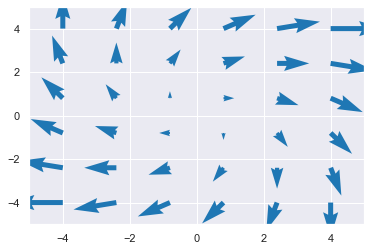

In [95]:
x = np.linspace(-4, 4, 6)
y = np.linspace(-4, 4, 6)
X, Y = np.meshgrid(x, y)
U = X + Y
V = Y - X

# plot
fig, ax = plt.subplots()

ax.quiver(X, Y, U, V, color="C0", angles='xy',
          scale_units='xy', scale=5, width=.015)

ax.set(xlim=(-5, 5), ylim=(-5, 5))

plt.show()